# Final assignment 
## Language switching experiment

##### Note/disclaimer: 
I've skipped quite a few steps here and there, simple because I was unable to figure out how to perform it correctly. After asking colleagues and spending way more time on this assignment than indicated, I decided to leave it like this :) 

## 0. Import all necessary libraries
Import sounddevice as given in the _hints_ file

In [3]:
import sounddevice as sd
import soundfile as sf
from psychopy import prefs
prefs.general['audioLib'] = ['pygame']
from psychopy import core, visual, event, gui, data, clock, logging
from psychopy.tools.filetools import fromFile, toFile
from psychopy.constants import (NOT_STARTED, STARTED, PLAYING, PAUSED, STOPPED, FINISHED, PRESSED, RELEASED, FOREVER)
import numpy as np
import os 
import sys
import pandas as pd
import seaborn as sns
import csv
from sklearn import linear_model
from sklearn.metrics import r2_score

## 1. Creating the experiment
### 1.1. Stimuli

The stimuli will consist of pictures, presented on one side of the screen. When a pictures is presented on the _left_ side of the screen, the picture needs to be named in L1. When a picture is presented on the _right_ side of the screen, the picture needs to be named in the L2. 

The stimuli are taken from the MultiPic project (Duñabeitia, J. A., Crepaldi, D., Meyer, A. S., New, B., Pliatsikas, C., Smolka, E., & Brysbaert, M. (2018). MultiPic: A standardized set of 750 drawings with norms for six European languages. Quarterly Journal of Experimental Psychology, 71(4), 808–816. https://doi.org/10.1080/17470218.2017.1310261). For this assignment, I decided to include seven pictures. 

These pictures need to be presented on the left or right side of the screen. Pictures on the left side need to be named in English and are therefore the "EN-trials". Pictures on the right side of the screen will need to be named in Dutch (i.e., all other trials). The pictures were supposed to stay on the screen for as long as it would take to name them. However, due to difficulties implementing a voicekey (model `pyo` could not be downloaded to my computer), I decided to leave the pictures on the screen for a fixed time, and record everything while the picture was shown. The reaction times were extracted later.

When I try to run the code from this Jupyter notebook, my computer can't handle it for some reason. So I've put everything in a script called `switch.py`, including explanations with the steps. To run the script:


In [4]:
#Try it out
import subprocess as sp

sp.run(['python', 'switch.py'])

CompletedProcess(args=['python', 'switch.py'], returncode=0)

### 1.2 Responses 

The participants need to _name_ the pictures, meaning that the responses will consist of a voice key. I tried to figure out how to do this, but wasn't able to. Instead, I used _sound device_ to record what the participants say for a fixed time, and then extract the reaction times like this:

In [5]:
path = 'C:/Users/saski/mpi-python-intro/Session6/recordings/' #Define the right directory
os.chdir(path)

rec = [] #Create an empty list for recordings

listRec = os.listdir('.') 

#Create a list of all the .wav files in the directory
for file in listRec:
    if file.endswith('.wav'):
         rec.append(file)

RTs = []
for files in rec:
    recordings, samplerate = sf.read(files) #Read all .wav files 
    energy = np.square(recordings) #create a variable "energy" of the squared recordings-array
    Emax = np.max(energy)
    energyNorm = (energy/Emax) #Normalize these values
    index = [index for index, value in enumerate(energyNorm) if value > 0.2] #Ok so this is quite unprecise and while there are multiple solutions to this problem (e.g., comparing multiple indices, getting rid of noise beforehand) , for this exercise I will keep it like this. 
    RT = index[0]/samplerate #This is the reaction time
    RTs.append(RT)
    #print(RT) #Sanity check


## 2.0 Plot the data 
After skipping some things I couldn't figure out (i.e., saving the data in the right format)..:

In [6]:
path = 'C:/Users/saski/mpi-python-intro/Session6/data/' #Define the right directory
os.chdir(path)
data = pd.read_excel('RT.xlsx') #Read excel
data.head() #See what data look like

,Item,Lang,Switch,Ptc,RT
0,brush,en,no,1,844.500000
1,saw,en,no,1,952.958333
2,button,en,no,1,859.833333
3,balloon,nl,yes,1,1156.458333
4,mask,nl,no,1,1227.270833


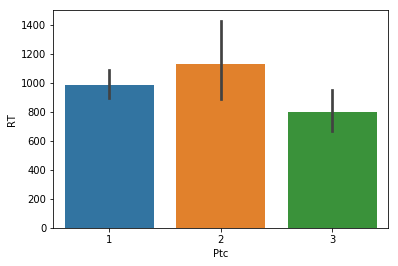

In [7]:
#Plot the data to first see the effects of participant
sns.barplot(x = 'Ptc', y = 'RT', data = data)

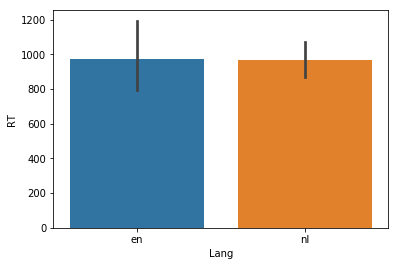

In [8]:
#Plot the data to see the effects of language
sns.barplot(x = 'Lang', y = 'RT', data = data)

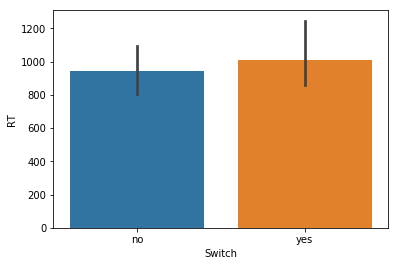

In [9]:
#Plot the data to see the effects of switching
sns.barplot(x = 'Switch', y = 'RT', data = data)

From the plots it appears that participant 1 is slowest to respond to the pictures, followed by participant 2 and 3. The two languages are responded to equally fast, while participants take longer to respond to the switch trials.

## 3.0 "Analyze" the data
The last step is to analyze the data using _scitkit_. 

In [10]:
#Regression models here need the predictors to be numeric, so:
data = pd.read_excel('RT.xlsx') #Read excel
dataNum = pd.get_dummies(data, columns = ['Switch', 'Lang'])
dataNum.head() #Check

,Item,Ptc,RT,Switch_no,Switch_yes,Lang_en,Lang_nl
0,brush,1,844.500000,1,0,1,0
1,saw,1,952.958333,1,0,1,0
2,button,1,859.833333,1,0,1,0
3,balloon,1,1156.458333,0,1,0,1
4,mask,1,1227.270833,1,0,0,1


In [12]:
#Using linear regression, first model

x = dataNum[['Switch_yes']]
y = dataNum['RT']
model1 = linear_model.LinearRegression()
model1.fit(x, y)
y_predicted = model1.predict(x)
r2 = r2_score(y, y_predicted)
print(f'The R squared of model 1 is {r2}')


The R squared of model 1 is 0.01478226387603665


In [13]:
#Second model
x = dataNum[['Switch_yes', 'Ptc']]
y = dataNum['RT']
model2 = linear_model.LinearRegression()
model2.fit(x, y)
y_predicted = model2.predict(x)
r2 = r2_score(y, y_predicted)
print(f'The R squared of model 2 is {r2}')

The R squared of model 2 is 0.08476025577048929


In [14]:
#Final model

x = dataNum[['Switch_yes', 'Ptc', 'Lang_en']]
y = dataNum['RT']
model3 = linear_model.LinearRegression()
model3.fit(x, y)
y_predicted = model3.predict(x)
r2 = r2_score(y, y_predicted)
print(f'The R squared of the final model is {r2}')

The R squared of the final model is 0.08973019024724771


#### Conclusion: we might need more data of  more participants to evaluate the effects of switching between languages in a picture naming task...